<a href="https://colab.research.google.com/github/minjeancho/FSGAN-/blob/main/autoencoder_faceswap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install comet
!pip install comet_ml

In [ ]:
from comet_ml import Experiment

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from torch.utils.data import Dataset

import os 
import numpy as np 
from skimage.transform import resize
from skimage.io import imread
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

In [ ]:
def get_image_data(root_dir):
    image_name_list = os.listdir(root_dir)
    image_list  = np.zeros((len(image_name_list), 64, 64, 3))
    for i in tqdm(range(len(image_name_list))):
        filename = image_name_list[i]
        path = os.path.join(root_dir, filename)
        image = imread(path)
        if len(image.shape) == 2:
            image = np.stack([image, image, image], axis=-1)
        image = resize(image, (64, 64, 3))
        image_list[i] = image

    # pytorch Conv2D expects num_channels first 
    image_list = np.swapaxes(image_list, -1, 1)
    return image_list

In [ ]:
class SourceDataset(Dataset):
  def __init__(self, root_dir):
    self.source_imgs = get_image_data(root_dir)
      
  def __len__(self):
    return len(self.source_imgs)

  def __getitem__(self, idx):
    item = {"source_img": self.source_imgs[idx]}
    return item 

class TargetDataset(Dataset):
  def __init__(self, root_dir):
    self.target_imgs = get_image_data(root_dir)
      
  def __len__(self):
    return len(self.target_imgs)

  def __getitem__(self, idx):
    item = {"target_img": self.target_imgs[idx]}
    return item 

In [ ]:
from torch import nn
import torch 

class Encoder(nn.Module):
  def __init__(self):
    super (Encoder, self).__init__()

    self.encoder = nn.Sequential(
        nn.Conv2d(3, 32, 3, 2, 1),
        nn.BatchNorm2d(32),
        nn.LeakyReLU(0.2),

        nn.Conv2d(32, 64, 3, 2, 1),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2),

        nn.Conv2d(64, 128, 3, 2, 1),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2),

        nn.Conv2d(128, 128, 3, 2, 1),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2)
    )
  def forward(self, x):
    return self.encoder(x)


class Decoder(nn.Module):
  def __init__(self):
    super (Decoder, self).__init__()

    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(128, 128, 3, 2, 1),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2),

        nn.ConvTranspose2d(128, 64, 5, 2, 1),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2),

        nn.ConvTranspose2d(64, 32, 5, 2, 1),
        nn.BatchNorm2d(32),
        nn.LeakyReLU(0.2),

        nn.ConvTranspose2d(32, 3, 5, 2, 1, 1),
        nn.BatchNorm2d(3),
        nn.LeakyReLU(0.2)
    )

  def forward(self, x):
    return self.decoder(x)


class SourceAE(nn.Module):
  def __init__(self):
    super(SourceAE, self).__init__()

    self.encoder = Encoder()
    self.decoder = Decoder()

  def forward(self, x):
    self.encoder = Encoder()
    self.decoder = Decoder()

  def forward(self, x):
    return self.decoder(self.encoder(x))

class TargetAE(nn.Module):
  def __init__(self):
    super(TargetAE, self).__init__()
    
    self.encoder = Encoder()
    self.decoder = Decoder()

  def forward(self, x):
    return self.decoder(self.encoder(x))

In [ ]:
print("Extracting source data...")
source_dataset = SourceDataset("/content/drive/My Drive/data/trump")
print("Done!")

Extracting source data...



Done!


In [ ]:
print("Extracting target data...")
target_dataset = SourceDataset("/content/drive/My Drive/data/cage")
print("Done!")

Extracting target data...



Done!


In [ ]:
def train(model, train_loader):
  with experiment.train():
    model.train()
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = hyperparams["lr"])

    for epoch in tqdm(range(hyperparams["epochs"])):
        for batch in train_loader:
          img = batch["source_img"].to(device=device, dtype=torch.float)
          img_pred = model(img)

          optimizer.zero_grad()
          loss = loss_fn(img_pred, img)
          loss.backward()
          optimizer.step()

def inference(model, train_loader):
  with experiment.test():
    for batch in train_loader:
      img = batch["source_img"].to(device=device, dtype=torch.float)
      img_pred = model(img)

      img = img.cpu().detach().numpy() 
      img_pred = img_pred.cpu().detach().numpy()

      img = np.swapaxes(img, -1, 1)
      img_pred = np.swapaxes(img_pred, -1, 1)


      for i in range(hyperparams["bsz"]):
        img_ = img[i]
        img_pred_ = img_pred[i]
        print("original image")
        plt.imshow(img_)
        plt.show()

        print("reconstructed image")
        plt.imshow(img_pred_)
        plt.show()
      break 

if __name__ == "__main__":
    experiment = Experiment(api_key="CPjn0JE1SVdtVaV3f8k2zwYMC",
                        project_name="deepfake", workspace="minjeancho")
  
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("DEVICE NAME: ", torch.cuda.get_device_name(0))

    hyperparams = {
        "lr": 0.001,
        "epochs": 100,
        "bsz": 16
    }

    source_model = SourceAE().to(device)
    target_model = TargetAE().to(device)

    #print("Extracting source data...")
    #source_dataset = SourceDataset("/content/drive/My Drive/data/trump")
    #print("Done!")
    source_train_loader = torch.utils.data.DataLoader(dataset=source_dataset, batch_size = hyperparams["bsz"], shuffle=True)
    # === train source AE with source images 
    print("Training source autoencoder...")
    train(source_model, source_train_loader)

    #print("Extracting target data...")
    #target_dataset = TargetDataset()
    #print("Done!")
    target_train_loader = torch.utils.data.DataLoader(dataset=target_dataset, batch_size = hyperparams["bsz"], shuffle=True)
    # == target encoder shares weight with source encoder 
    target_model.encoder.load_state_dict(source_model.encoder.state_dict())
    # === train target AE with target images 
    print("Training target autoencoder...")
    train(target_model, target_train_loader)

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/minjeancho/deepfake/c8abd62740f34eb28df6ec9c4368df57
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [5] : (0.07882983982563019, 0.47725558280944824)
COMET INFO:   Uploads:
COMET INFO:     environment details : 1
COMET INFO:     filename            : 1
COMET INFO:     installed packages  : 1
COMET INFO:     model graph         : 1
COMET INFO:     os packages         : 1
COMET INFO: ---------------------------
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/minjeancho/deepfake/05aa558006964b2c97b35a64e70a8630



DEVICE NAME:  Tesla P4
Training source autoencoder...


original image


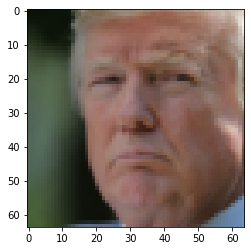

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image


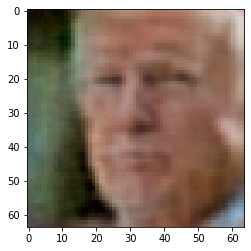

original image


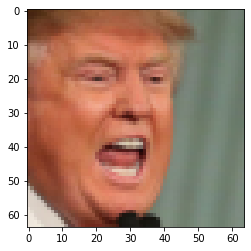

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image


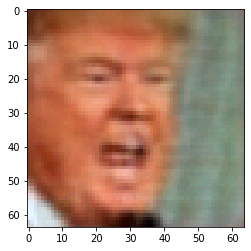

original image


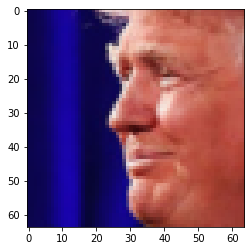

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image


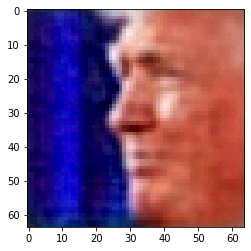

original image


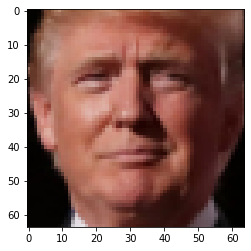

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image


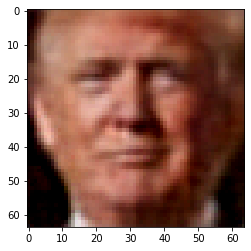

original image


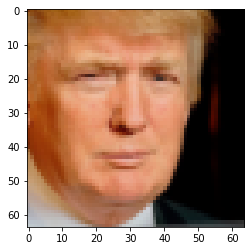

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image


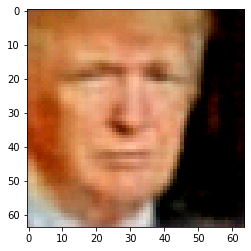

original image


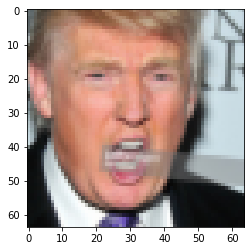

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image


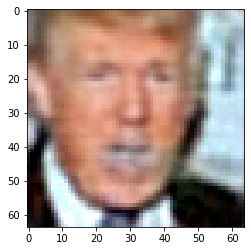

original image


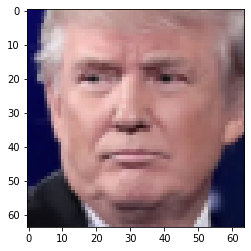

reconstructed image


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


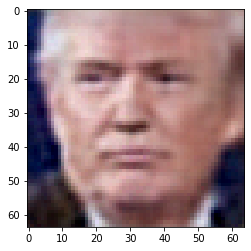

original image


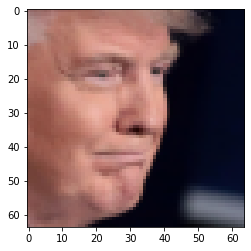

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image


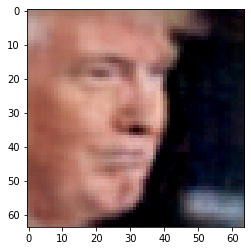

original image


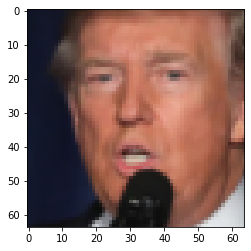

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image


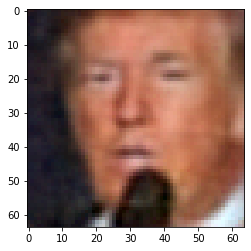

original image


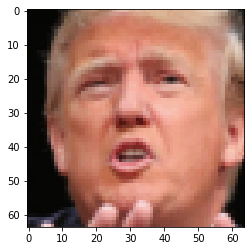

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image


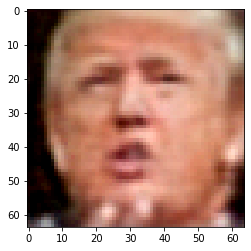

original image


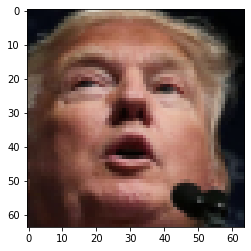

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image


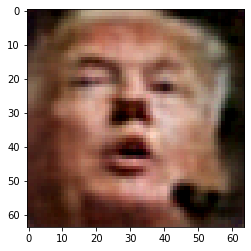

original image


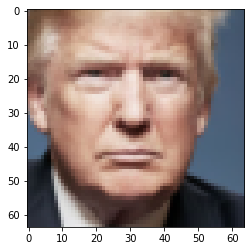

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image


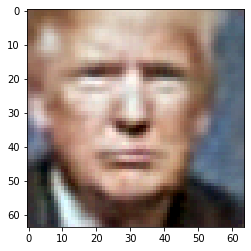

original image


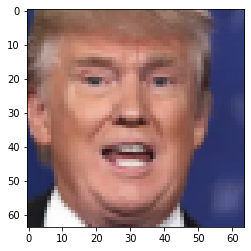

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image


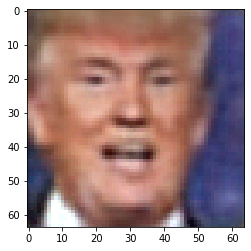

original image


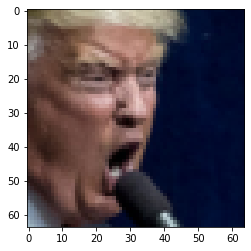

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image


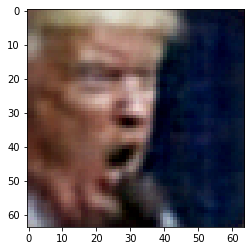

original image


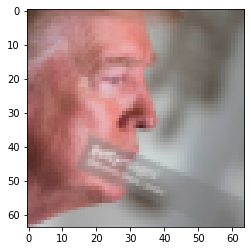

reconstructed image


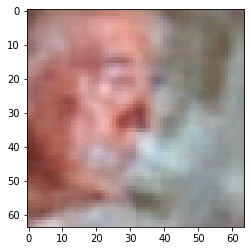

original image


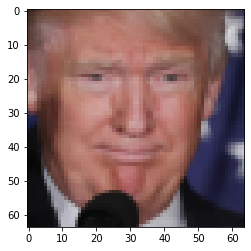

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image


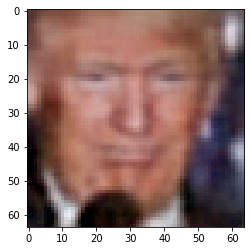

In [ ]:
inference(source_model, source_train_loader)

original image


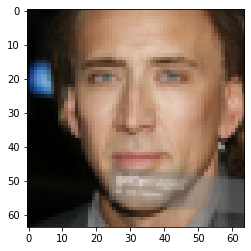

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image


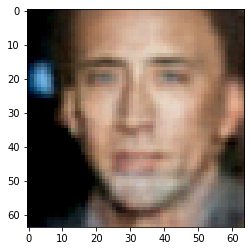

original image


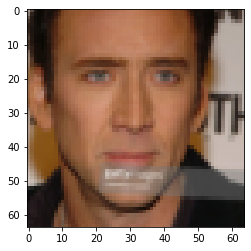

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image


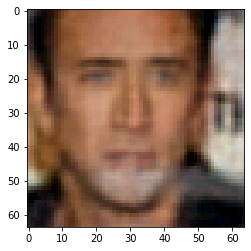

original image


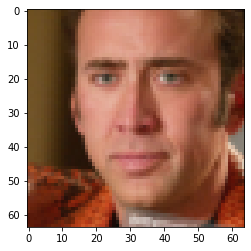

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image


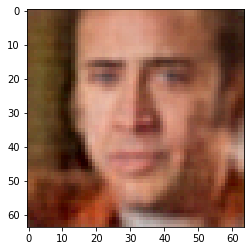

original image


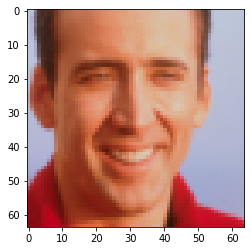

reconstructed image


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


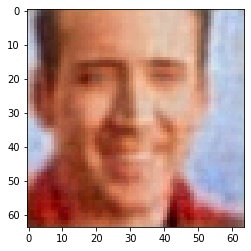

original image


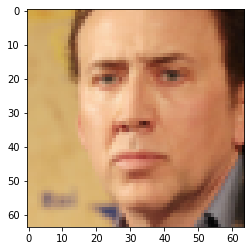

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image


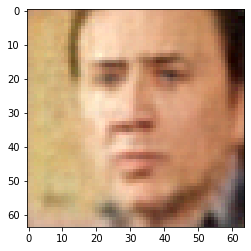

original image


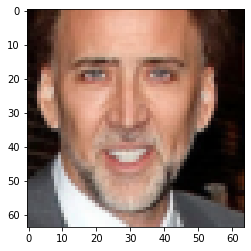

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image


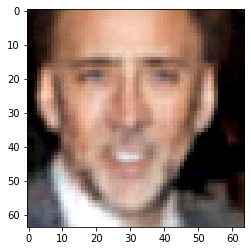

original image


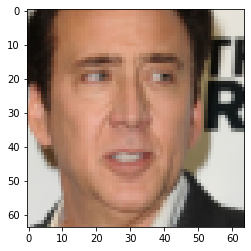

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image


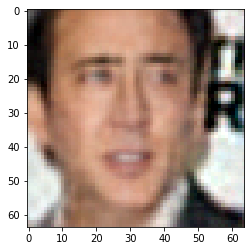

original image


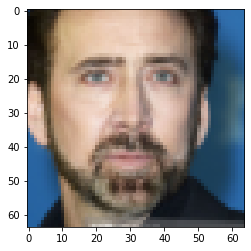

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image


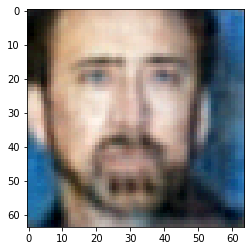

original image


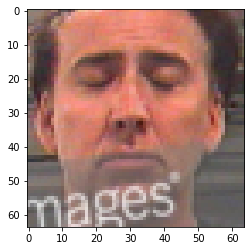

reconstructed image


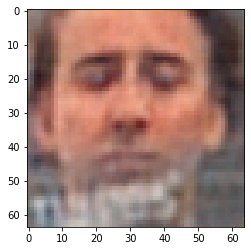

original image


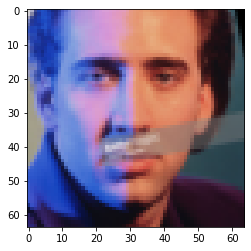

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image


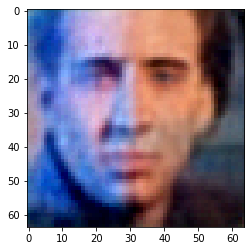

original image


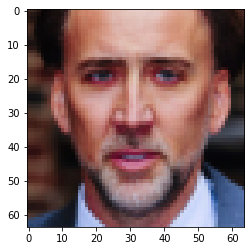

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image


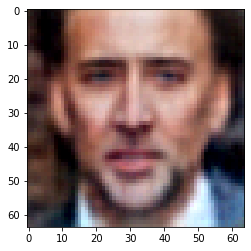

original image


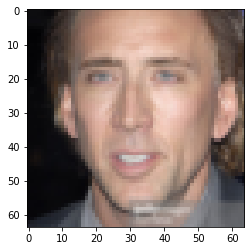

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image


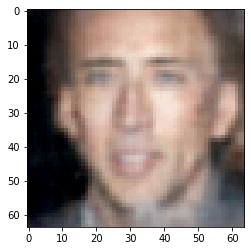

original image


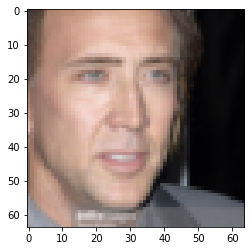

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image


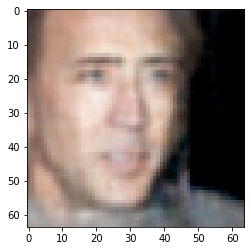

original image


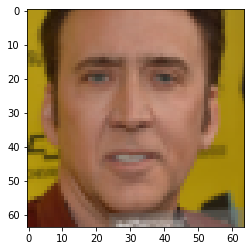

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image


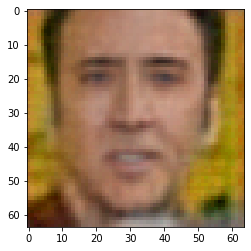

original image


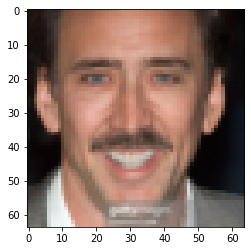

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image


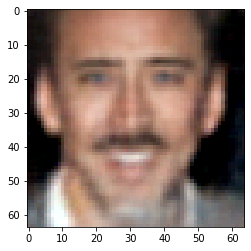

original image


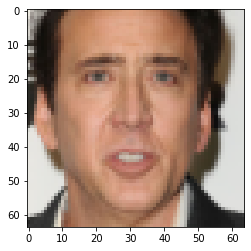

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image


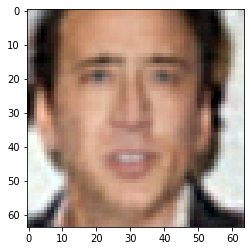

In [ ]:
inference(target_model, target_train_loader)

In [ ]:
def face_swap(source_loader, target_model):
  with experiment.test():
    for batch in source_loader:
      img = batch["source_img"].to(device=device, dtype=torch.float)
      img_pred = target_model(img)

      img = img.cpu().detach().numpy() 
      img_pred = img_pred.cpu().detach().numpy()

      img = np.swapaxes(img, -1, 1)
      img_pred = np.swapaxes(img_pred, -1, 1)


      for i in range(hyperparams["bsz"]):
        img_ = img[i]
        img_pred_ = img_pred[i]
        print("original image")
        plt.imshow(img_)
        plt.show()

        print("swapped image")
        plt.imshow(img_pred_)
        plt.show()
      break 

original image


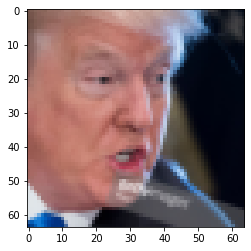

reconstructed image


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


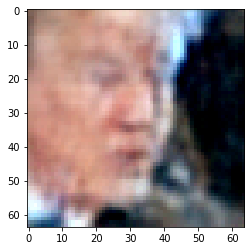

original image


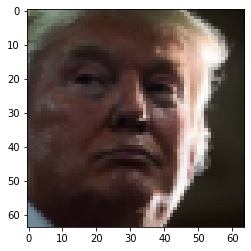

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image


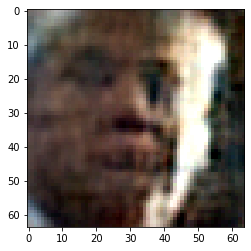

original image


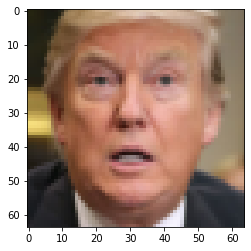

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image


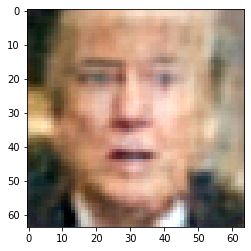

original image


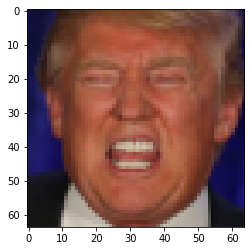

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image


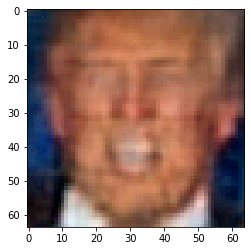

original image


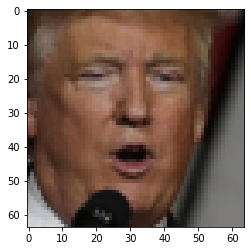

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image


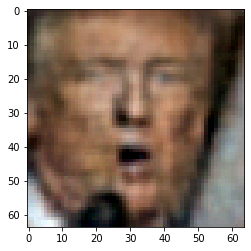

original image


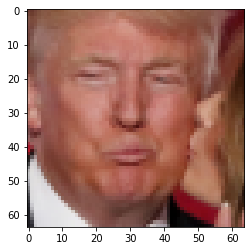

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image


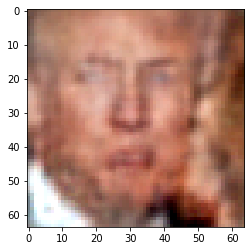

original image


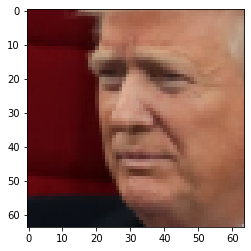

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image


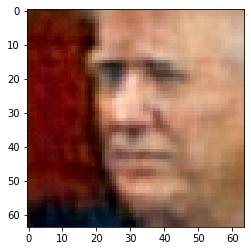

original image


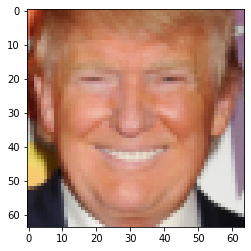

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image


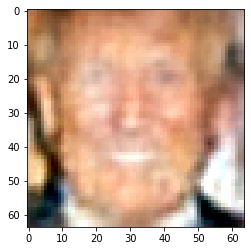

original image


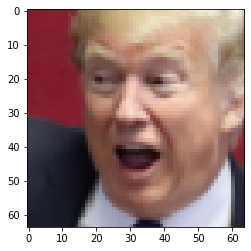

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image


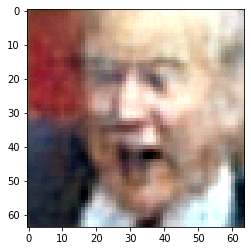

original image


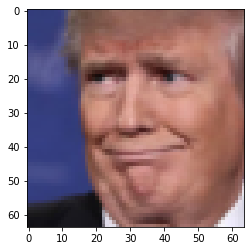

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image


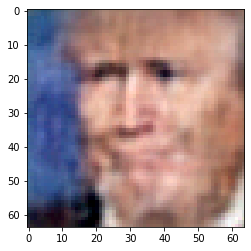

original image


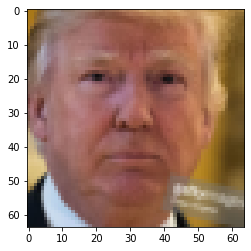

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image


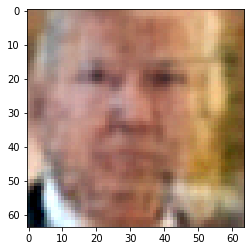

original image


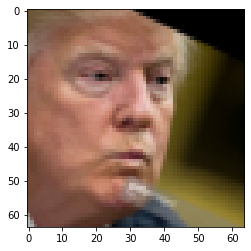

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image


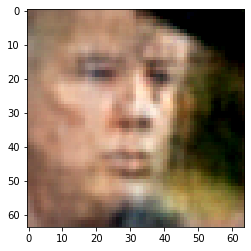

original image


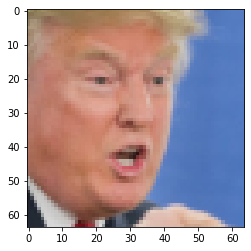

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image


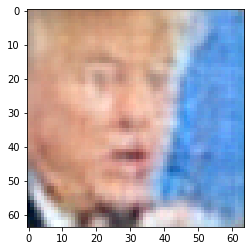

original image


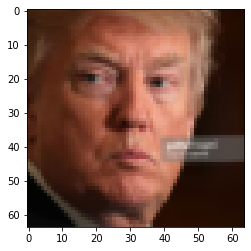

reconstructed image


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


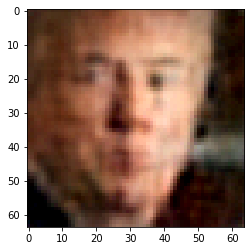

original image


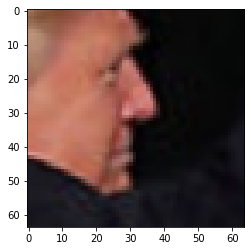

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image


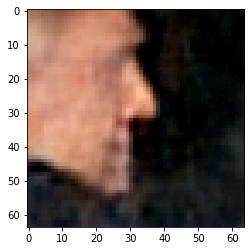

original image


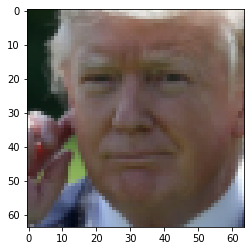

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed image


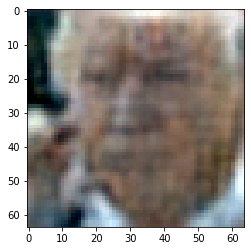

In [ ]:
face_swap(source_train_loader, target_model)